# discrete_tf - Pythonize

Use Python's syntactic sugar to 'pythonize' the Simulink Model. This class wraps the Simulink Model with some Python concepts. In addition to wrapping all of the functions with Python, it builds in a data-logger and plotting.

This has been tested on both Windows and Linux. Most of the python logic stays the same, the only difference is how the shared library is loaded.

![](discrete_tf.png)

# Python Setup

In [1]:
import sys

from discretetf import DiscreteTF

mdl = DiscreteTF()

In [4]:
mdl.initialize()
mdl

discrete_tf<0.0, 0.0, 0.0>

In [5]:
mdl.step()
mdl

discrete_tf<0.0, 0.0, 0.0>

In [6]:
mdl.step()
mdl

discrete_tf<0.001, 0.0, 0.0>

In [7]:
mdl.step()
mdl

discrete_tf<0.002, 0.0, 0.0>

In [8]:
mdl.num

[0.0, 0.0014996250624921886]

In [9]:
mdl.den

[1.0, -0.9995001249791693]

# Validate against `control` toolbox.

In [10]:
import control
import numpy as np

In [11]:
# How fast the simulink model is running.
Ts=1e-3
# Static Gain
K = 3
# Time Constant.
tau = 2
sys = control.TransferFunction([K], [tau, 1])
sysd = control.c2d(sys, Ts)
sysd

TransferFunction(array([0.00149963]), array([ 1.        , -0.99950012]), 0.001)

In [12]:
sysd.num

[[array([0.00149963])]]

In [13]:
mdl.num

[0.0, 0.0014996250624921886]

In [14]:
np.isclose(sysd.num, mdl.num)

array([[[False,  True]]])

In [15]:
sysd.den

[[array([ 1.        , -0.99950012])]]

In [16]:
mdl.den

[1.0, -0.9995001249791693]

In [17]:
np.isclose(sysd.den, mdl.den)

array([[[ True,  True]]])

# Pythonic Interactions

In [18]:
mdl.initialize()
for step in range(int(15/Ts)+1):
    mdl.step()
mdl.time

15.0

## Using the Datalogger

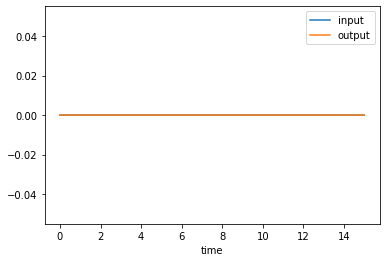

In [19]:
data = dict()
mdl.init_log()
for step in range(int(15/Ts)+1):
    mdl.step_log()
mdl.plot()

# Step Response

- Plot step response for a first order system with $\tau=1s,2s,3s$ for K=1. Make the step at 2s.
- The model is compiled with K=3, $\tau=2s$
- The simulink model is running at 0.001s.

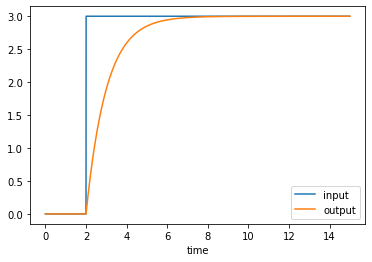

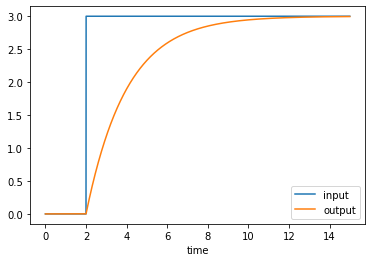

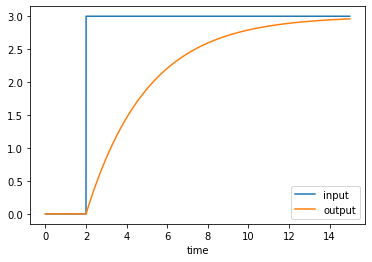

In [20]:
dt=0.001
K = 1
dataframes = list()
for tau in [1, 2, 3]:
    sys = control.TransferFunction([K], [tau, 1])
    sysd = control.c2d(sys, Ts)
    mdl.num = sysd.num[0][0]
    mdl.den = sysd.den[0][0]
    mdl.init_log()
    for step in range(int(15/Ts)):
        mdl.input_signal = 3 if mdl.time>=2 else 0
        mdl.step_log()
    mdl.plot()
    dataframes.append(mdl.dataframe)

In [21]:
dataframes[0].rename(columns={"output": "output_tau1"}, inplace=True)
dataframes[1].rename(columns={"output": "output_tau2"}, inplace=True)
dataframes[2].rename(columns={"output": "output_tau3"}, inplace=True)

In [22]:
df = dataframes[0].append(dataframes[1]).append(dataframes[2])

<AxesSubplot:xlabel='time'>

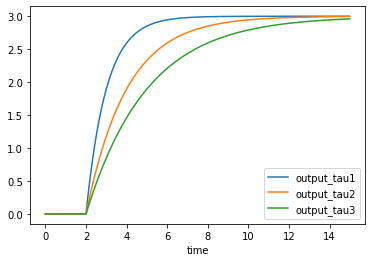

In [23]:
df.plot(x='time', y=["output_tau1", "output_tau2", "output_tau3"])

# Sine Response

- Input a sine-wave to the system. Estimate the mag/phase and compare to the ```control.bode``` function.
- The simulink model is running at 0.001s.

In [24]:
import random

In [25]:
# "Black box"
K = random.randint(1, 10)
tau = random.randint(1, 10)
sys = control.TransferFunction([K], [tau, 1])
sysd = control.c2d(sys, Ts)
mdl.num = sysd.num[0][0]
mdl.den = sysd.den[0][0]

### Solution

In [26]:
def input_fcn(step, freq):
    """Function to simplify calculate sine response given step and frequency (hz)."""
    return np.sin(2*np.pi*freq*step/1000)

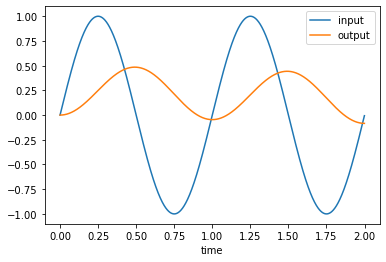

In [27]:
mdl.init_log()
for step in range(int(2/Ts)):
    mdl.input_signal = input_fcn(step, 1)
    mdl.step_log()
mdl.plot()
dataframes.append(mdl.dataframe)

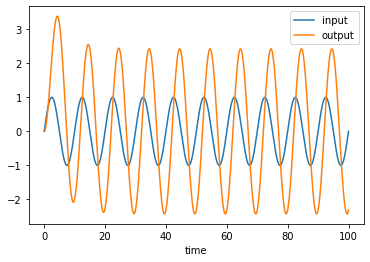

In [28]:
f=0.1
cycles=10 # Pick an even number
mdl.init_log()
for step in range(int((cycles*1/f)/Ts)):
    mdl.input_signal = input_fcn(step, f)
    mdl.step_log()
mdl.plot()

Select the last half of the data after it has 'setttled'.

<AxesSubplot:xlabel='time'>

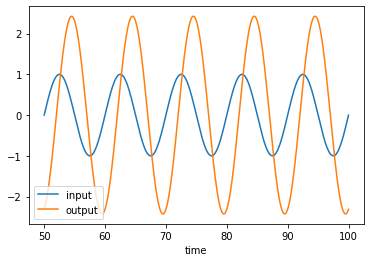

In [29]:
df=mdl.dataframe[int(len(mdl.dataframe)/2):]
df.plot(x="time", y=["input", "output"])

In [30]:
df.input.max()

1.0

In [31]:
df.output.max()

2.4265584059821546

In [32]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error 

In [33]:
def minfunc(*args):
    """Function to calculate error between estimate function and output."""
    # Amplitude
    A=args[0][0]
    # Phase in Radians/s
    phi=args[0][1]
    # DC Offset
    dc =args[0][2]
    
    output_p = A*np.sin(2*np.pi*f*df.time+phi)+dc
    return mean_squared_error(output_p, df.output)

x0=[8.7, -np.pi/4, 0]
results = minimize(minfunc, x0)
results

      fun: 4.207531828825403e-10
 hess_inv: array([[ 1.04036636e+00, -7.54360213e-04,  1.31556505e-02],
       [-7.54360213e-04,  1.69844080e-01, -2.47097878e-04],
       [ 1.31556505e-02, -2.47097878e-04,  5.04287334e-01]])
      jac: array([-3.25305716e-07,  3.57571004e-08, -2.12037680e-07])
  message: 'Optimization terminated successfully.'
     nfev: 44
      nit: 10
     njev: 11
   status: 0
  success: True
        x: array([ 2.42651547e+00, -1.26293880e+00,  1.03855425e-05])

In [34]:
mag, phase, omega = control.bode(sysd, omega=[2*np.pi*f], plot=False)
print(f"mag={mag}@{omega/(2*np.pi)}Hz")
print(f"phase={phase}@{omega/(2*np.pi)}Hz")

mag=[2.42651581]@[0.1]Hz
phase=[-1.26294143]@[0.1]Hz


The magnitude and phase of the output signal match the bode analysis results.

In [35]:
np.isclose(mag,results.x[0])

array([ True])

In [36]:
np.isclose(phase,results.x[1])

array([ True])